# Contrast activity for similar motor movements (motor control)

In [1]:
import numpy as np
import pandas as pd
import physutils as phys
import physutils.bootstrap as boot
import physutils.tf as tf
import matplotlib.pyplot as plt
import dbio
%matplotlib inline


In [2]:
import os
dbname = os.path.expanduser('data/bart.hdf5')
dtup = 18, 1

In [3]:
lfp = dbio.fetch_all_such_LFP(dbname, *dtup)

Clean up by censoring, zscoring, and taking the mean:


In [4]:
if lfp.shape[1] > 1:
    lfpdm = lfp.demean_global()
else:
    lfpdm = lfp
lfpmz = lfpdm.censor().rzscore()
nanrows = np.any(np.isnan(lfpmz), axis=1)
lfpm = lfpmz.mean(axis=1)
lfpm[nanrows] = np.nan

In [5]:
lfpm = phys.LFPset(lfpm)

Grab events:

In [6]:
evt = dbio.fetch_all_such(dbname, 'events', *dtup)

Get stops and pops, plus which ones are control?

In [7]:
stops = evt['banked'].dropna()
pops = evt['popped'].dropna()
starts = evt['start inflating']
if 'is_control' in evt.columns:
    stops_free = evt.query('is_control == False')['banked'].dropna()
    stops_control = evt.query('is_control == True')['banked'].dropna()
    stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
    stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
else:
    stops_free = stops
    stops_rewarded = stops

In [8]:
Tpre = -1.5
Tpost = 1.0
freqs = np.exp(np.linspace(np.log(2.5), np.log(50), 50))

## Question: how much activity is due to motor movement?

The joystick click to start the trial is identical to the joystick click to stop the trial. Let's look at the time preceding each to see what activity might distinguish the trial end action.

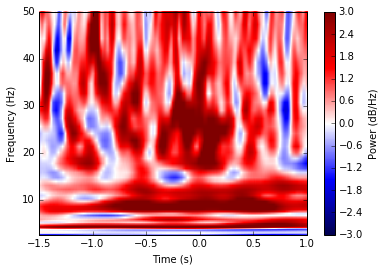

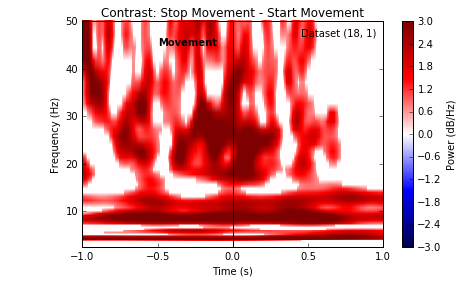

In [10]:
contr_tf, fig = lfpm.contrast_time_frequency(0, [stops_free, starts], 
                                             Tpre, Tpost, method='wav',
                                             freqs=freqs, clim=(-3, 3), rasterized=True, cmap='seismic', bandwidth=9)
mcontr, fig = lfpm.significant_time_frequency(0, [stops_free, starts], 
                                             Tpre, Tpost, thresh=(0.1, 0.9), 
                                             freqs=freqs,
                                             niter=100, method='wav', 
                                             doplot=True, clim=(-3, 3), rasterized=True, cmap='seismic', bandwidth=9)

# decorations
plt.axvline(x=0, color='k')
plt.text(-0.5, 45, 'Movement', fontweight='bold')
plt.text(0.45, 47, "Dataset {}".format(str(dtup)))

plt.title('Contrast: Stop Movement - Start Movement')

plt.tick_params(axis='x', which='both', top='off');
plt.xlim(-1, 1)

plt.tight_layout()
plt.savefig("figures/stops_starts_tf_contrast.svg")